# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [ ]:
# Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import to_categorical # np_utils has been replaced with to_categorical

from six.moves import cPickle as pickle
from six.moves import range


import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipython-input-1-2370924151.py:8: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [ ]:
# Setting the random seed so that the results are reproducible.
random.seed(42)


In [ ]:
import numpy as np
import scipy.io as sio
import pickle
from sklearn.model_selection import train_test_split

# Load the .mat files
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')

# Extract images and labels
X_train = np.transpose(train_data['X'], (3, 0, 1, 2))
y_train = train_data['y'].flatten()
X_test = np.transpose(test_data['X'], (3, 0, 1, 2))
y_test = test_data['y'].flatten()

# Replace label '10' with '0'
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

# Split training into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

# Save as pickle
pickle_file = 'SVHN_multi_crop.pickle'
try:
    with open(pickle_file, 'wb') as f:
        save = {
            'train_dataset': X_train,
            'train_labels': y_train,
            'valid_dataset': X_valid,
            'valid_labels': y_valid,
            'test_dataset': X_test,
            'test_labels': y_test,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    print(f"Pickle file saved as '{pickle_file}'")
except Exception as e:
    print(f"Unable to save data to {pickle_file}: {e}")


Pickle file saved as 'SVHN_multi_crop.pickle'


## Load Dataset

In [ ]:
pickle_file = 'SVHN_multi_crop.pickle'

# Check if the pickle file exists
import os
if not os.path.exists(pickle_file):
    print(f"Error: File '{pickle_file}' not found.")
else:
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_dataset = save['train_dataset']
        train_labels = save['train_labels']
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']
        del save  # hint to help gc free up memory
        print('Training set', train_dataset.shape, train_labels.shape)
        print('Validation set', valid_dataset.shape, valid_labels.shape)
        print('Test set', test_dataset.shape, test_labels.shape)

Training set (65931, 32, 32, 3) (65931,)
Validation set (7326, 32, 32, 3) (7326,)
Test set (26032, 32, 32, 3) (26032,)


Label for image: 0


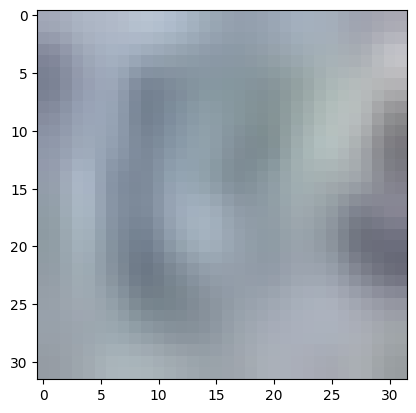

In [ ]:
plt.figure()
plt.imshow(train_dataset[50], cmap='gray')

print("Label for image: {}".format(train_labels[50]))

## Convert Labels
This function converts each digit label to one-hot array.

In [ ]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    """Converts single digit labels to a sequence of labels with padding,
    and then converts the sequence to one-hot encoded arrays.
    """
    # Assuming labels are single digits, create a sequence with padding
    # and then one-hot encode each digit in the sequence.
    sequences = []
    for label in labels:
        # Create a sequence of length 5, with the actual digit followed by 10s (padding)
        sequence = [label] + [10] * 4 # Pad with 10 to represent empty digits
        sequences.append(sequence)

    # Now, convert each digit in the sequences to one-hot encoding
    dig0_arr = np.ndarray(shape=(len(sequences), possible_classes))
    dig1_arr = np.ndarray(shape=(len(sequences), possible_classes))
    dig2_arr = np.ndarray(shape=(len(sequences), possible_classes))
    dig3_arr = np.ndarray(shape=(len(sequences), possible_classes))
    dig4_arr = np.ndarray(shape=(len(sequences), possible_classes))

    for index, sequence in enumerate(sequences):
        dig0_arr[index, :] = to_categorical(sequence[0], possible_classes)
        dig1_arr[index, :] = to_categorical(sequence[1], possible_classes)
        dig2_arr[index, :] = to_categorical(sequence[2], possible_classes)
        dig3_arr[index, :] = to_categorical(sequence[3], possible_classes)
        dig4_arr[index, :] = to_categorical(sequence[4], possible_classes)

    return [dig0_arr, dig1_arr, dig2_arr, dig3_arr, dig4_arr]

In [ ]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [ ]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(65931, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [ ]:
import cv2

def prep_data_keras(img_data):
    # Assuming input shape is (num_samples, 32, 32, 3)

    # Convert images to grayscale and resize to 64x64
    processed_data = np.ndarray(shape=(len(img_data), 64, 64), dtype=np.float32)
    for i in range(len(img_data)):
        # Convert to grayscale
        gray_img = cv2.cvtColor(img_data[i], cv2.COLOR_RGB2GRAY)
        # Resize to 64x64
        resized_img = cv2.resize(gray_img, (64, 64))
        processed_data[i] = resized_img

    # Reshaping data for keras, with tensorflow as backend
    # Add channel dimension
    processed_data = processed_data.reshape(len(processed_data), 64, 64, 1)

    # Converting everything to floats (already done during processing)
    # processed_data = processed_data.astype('float32')

    # Normalizing values between 0 and 1
    processed_data /= 255.0

    return processed_data

In [ ]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [ ]:
np.shape(train_images)

(65931, 64, 64, 1)

In [ ]:
np.shape(test_images)

(26032, 64, 64, 1)

In [ ]:
# Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

## Build Model
Build Deep Learning model to process data.

In [ ]:
# Building the model

batch_size = 32
nb_classes = 11
nb_epoch = 10 # Reduced number of epochs

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

# number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# defining the input
inputs = Input(shape=(img_rows, img_cols, img_channels))

# Model taken from keras example.
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(inputs)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D(nb_filters,kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 2),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)


cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 4),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]), use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = Conv2D((nb_filters * 8),kernel_size=(kernel_size[0],kernel_size[1]),padding='same', use_bias=False)(cov)
cov = BatchNormalization()(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.3)(cov)

cov_out = Flatten()(cov)


# Dense Layers
cov2 = Dense(2056, activation='relu')(cov_out)
cov2 = Dropout(0.3)(cov2)



# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())


# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

# Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images, valid_labels), callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 30, 30,    │     18,432 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 15,    │          0 │ max_pooling2d_1[

 Total params: 3,395,095 (12.95 MB)

 Trainable params: 3,393,175 (12.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/10
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 70s 25ms/step - dense_1_accuracy: 0.3409 - dense_1_loss: 2.0864 - dense_2_accuracy: 0.9973 - dense_2_loss: 0.0083 - dense_3_accuracy: 0.9961 - dense_3_loss: 0.0149 - dense_4_accuracy: 0.9961 - dense_4_loss: 0.0125 - dense_5_accuracy: 0.9960 - dense_5_loss: 0.0175 - loss: 2.1397 - val_dense_1_accuracy: 0.8466 - val_dense_1_loss: 0.4934 - val_dense_2_accuracy: 1.0000 - val_dense_2_loss: 1.5798e-05 - val_dense_3_accuracy: 1.0000 - val_dense_3_loss: 1.6066e-05 - val_dense_4_accuracy: 1.0000 - val_dense_4_loss: 1.7775e-05 - val_dense_5_accuracy: 1.0000 - val_dense_5_loss: 1.3793e-05 - val_loss: 0.4934
Epoch 2/10
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - dense_1_accuracy: 0.8679 - dense_1_loss: 0.4353 - dense_2_accuracy: 1.0000 - dense_2_loss: 6.5463e-05 - dense_3_accuracy: 1.0000 - dense_3_loss: 8.6490e-05 - dense_4_accuracy: 1.0000 - dense_4_loss: 7.4749e-05 - dense_5_accuracy: 1.0000 - dense_5_loss: 7.1169e-05 - loss: 0.4356 - val_dense_

In [ ]:
predictions = model.predict(test_images)

814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [ ]:
np.shape(predictions)

(5, 26032, 11)

In [ ]:
len(predictions[0])

26032

In [ ]:
np.shape(test_labels)
print(predictions[0][0])
print(np.argmax(predictions[0][0]))

[7.7529609e-07 1.7656761e-04 2.1600625e-05 5.0334603e-04 5.5387286e-06
 9.9623233e-01 1.8707674e-03 1.1754914e-03 1.3538437e-06 1.2341631e-05
 3.1460481e-14]
5


## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [ ]:
def calculate_acc(predictions,real_labels):

    individual_counter = 0
    global_sequence_counter = 0
    coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0

        for j in range(0,5):

            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
            if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                coverage_counter += 1

        if sequence_counter == 5:
            global_sequence_counter += 1

    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
    coverage = coverage_counter / float(len(predictions[0]) * 5)

    return ind_accuracy,global_accuracy, coverage

In [ ]:
ind_acc, glob_acc, coverage = calculate_acc(predictions, test_labels)

In [ ]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))
print("The coverage is {} %".format(coverage * 100))

The individual accuracy is 98.57636754763368 %
The sequence prediction accuracy is 92.8818377381684 %
The coverage is 98.06776275353411 %


Actual labels: [np.int64(3), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]
Predicted labels: [np.int64(3), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]

Actual labels: [np.int64(5), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]
Predicted labels: [np.int64(5), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]

Actual labels: [np.int64(9), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]
Predicted labels: [np.int64(9), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]

Actual labels: [np.int64(6), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]
Predicted labels: [np.int64(9), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]

Actual labels: [np.int64(3), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]
Predicted labels: [np.int64(3), np.int64(10), np.int64(10), np.int64(10), np.int64(10)]



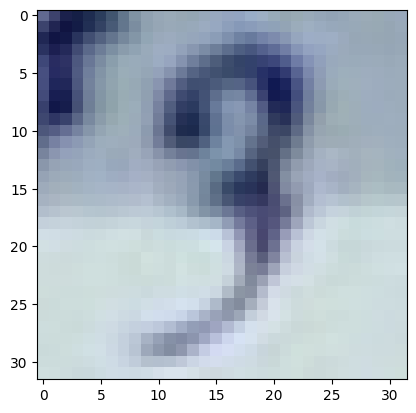

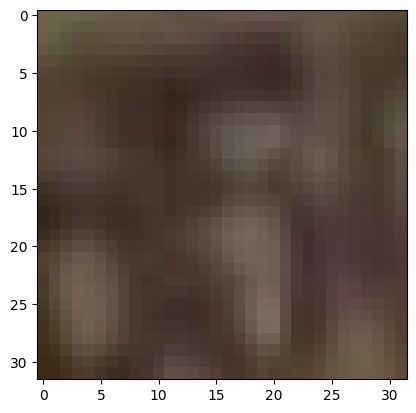

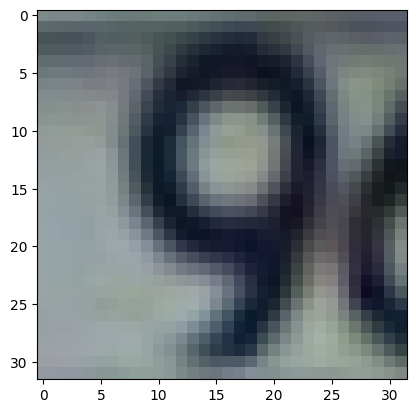

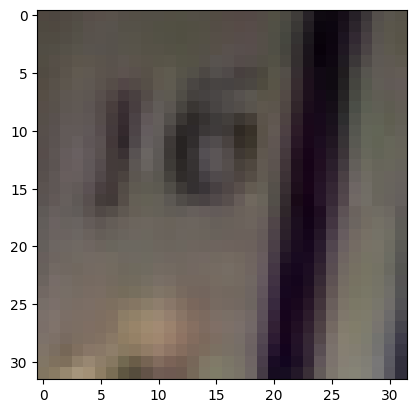

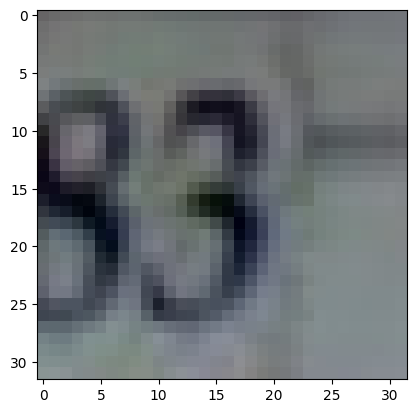

In [ ]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):

    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))

    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))